In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from numpy.random import uniform
from numpy.random import normal
from numpy.random import triangular

In [3]:
N=10**6

# Densidad del aire del CIPM-2007

Todas las constantes y funciones implementadas provienen del artículo *Revised formula for the density of moist air (CIPM-2007)* de A Picard, R S Davis, M Gläser y K Fujii del $2008$, este se puede visitar en https://www.nist.gov/system/files/documents/calibrations/CIPM-2007.pdf.

La constante de los gases ideales $R$ se tomó de https://physics.nist.gov/cgi-bin/cuu/Value?r|search_for=R, pues es el valor más actualizado.

In [4]:
def Psv(T):
    '''
    Función que calcula la presión de vapor de saturación siguiendo la fórmula que se presenta en el artículo de referencia.
    Input:
    -------------
    T: temperatura en °C.
    
    Output:
    -------------
    Psv: valor de la presión de vapor de saturación en hPa.
    '''
    A=0.000012378847
    B=-0.019121316
    C=33.93711047
    D=-6343.1645
    return np.exp(A*(T+273.15)**2+B*(T+273.15)+C+D/(T+273.15))/100

In [5]:
def f(P,T):
    '''
    Función que calcula el factor de fugasidad siguiendo la ecuación de la referencia.
    
    Input:
    --------------
    P: presión en Pa.
    T: temperatura en °C.
    
    Output:
    --------------
    f: Valor del coeficiente de fugacidad.
    '''
    alpha=1.00062
    beta=0.0000000314
    gamma=0.00000056
    return alpha+beta*P/100+gamma*T**2

In [6]:
def xv(Hr,P,T):
    '''
    Función que calcula la fracción molar de vapor de agua siguiendo el artículo de referencia.
    
    Input:
    ---------------
    Hr: humedad relativa como un valor entre 0 y 1.
    P: presión atmosférica en Pa.
    T: Temperatura en °C.
    
    Output:
    ---------------
    xv: Valor de la fracción molar de vapor de agua.
    '''
    return Hr*f(P,T)*Psv(T)/P/100

In [7]:
def Z(P,Hr,T):
    '''
    Función que calcula el factor de compresibilidad con la ecuación del artículo de referencia.
    
    Input:
    --------------
    P: Presión atmosférica en Pa.
    Hr: Humedad relativa como un valor entre 0 y 1.
    T: Temperatura en °C.
    
    Output:
    ---------------
    Z: factor de compresibilidad.
    '''
    a0=1.58123e-6
    a1=-2.9331e-8
    a2=1.1043e-10
    b0=5.703e-6
    b1=-2.051e-8
    c0=1.9898e-4
    c1=-2.376e-6
    d=1.83e-11
    e=-7.65e-9
    # T+=273.15
    # P/=100
    return 1-(P/100)/(T+273.15)*(a0+a1*T+a2*T**2+(b0+b1*T)*xv(Hr,P,T)+(c0+c1*T)*xv(Hr,P,T)**2)+(P/100)**2/(T+273.15)**2*(d+e*xv(Hr,P,T)**2)

In [8]:
def DensidadCIPM(P,Hr,T):
    '''
    Función que calcula la densidad del aire a partir de la ecuación del artículo de referencia.
    
    Input:
    --------------
    P: Presión atmosférica en Pa.
    Hr: Humedad relativa como un valor entre 0 y 1.
    T: Temperatura en °C.
    
    Output:
    DensidadCIPM: densidad del aire en kg/m^3.
    '''
    Ma=0.02896546
    Mv=0.018015
    R=8.314462618
    # print(f(P,T))
    # print(Z(P,Hr,T))
    # print(xv(Hr,P,T))
    # print(Psv(T))
    return (Ma*P+(Mv-Ma)*Hr*f(P,T)*Psv(T))/(Z(P,Hr,T)*R*(T+273.15))

En la Hoja de Cálculo la incertidumbre de la densidad del aire, dada su complejidad, se estima por medio del método de Kragten.

Las fuentes de incertidumbre para las magnitudes de entrada son: gradiente, certificado, deriva y resolución, de forma que se puede hacer un muestreo aleatorio asignando las distribuciones que corresponden: rectangular para el gradiente, la resolución y la deriva, normal para el certificado.

In [9]:
P=(101280+87880)/2+normal(0,976.6/2,N)+uniform(-10/2,10/2,N)+triangular(-101280+87880,0,101280-87880,N)+uniform(-976.6,976.6,N)
Hr=(0.56+0.55)/2+normal(0,2.6/100/2,N)+uniform(-0.001/2,0.001/2,N)+triangular(-56/100+55/100,0,56/100-55/100,N)+uniform(-2.6/100,2.6/100,N)
T=(20.1+20)/2+normal(0,0.7/2,N)+uniform(-0.1/2,0.1/2,N)+triangular(-20.1+20,0,20.1-20,N)+uniform(-0.7,0.7,N)

In [10]:
densidad=DensidadCIPM(P,Hr,T)

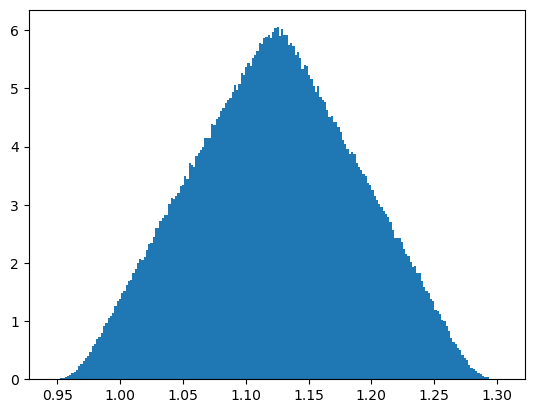

In [11]:
plt.hist(densidad,bins=200,density=True)
plt.show()

In [12]:
densidad.mean(),densidad.std()

(1.1236830413256103, 0.06562870462411838)

# Incertidumbre por empuje del aire

Habiendo calculado la densidad del aire durante la calibración, es necesario estimar la incertidumbre relativa por empuje del aire para la corrección relativa por efecto boyante, las cuales estarán dadas por:

$$\frac{\delta m_B}{m_c}=-\left(\rho_a-\rho_0\right)\left(\frac{1}{\rho}-\frac{1}{\rho_c}\right)$$

Que tiene una incertidumbre estándar relativa de:

$$\hat{w}^2(\delta m_B)=\left(\frac{1}{\rho}-\frac{1}{\rho_c}\right)^2u^2(\rho_a)+\frac{\left(\rho_a-\rho_0\right)^2}{\rho^4}u^2(\rho)$$

Sin embargo, en la Hoja de Cálculo esta incertidumbre es estimada por medio del método de Kragten, al igual que incertidumbre de la densidad del aire.

In [13]:
def DeltaBoyante(rho_a,rho):
    return -(rho_a-1.2)*(1/rho-1/8000)

In [14]:
rho_pesas=7950+normal(0,140/2,N)
dmB=DeltaBoyante(densidad,rho_pesas)

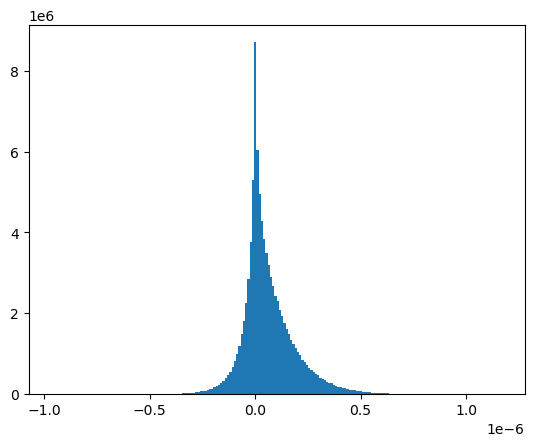

In [15]:
plt.hist(dmB,bins=200,density=True)
plt.show()

In [16]:
dmB.mean(),dmB.std()

(6.085163777523347e-08, 1.2302557923995643e-07)